<a href="https://colab.research.google.com/github/drdww/OPIM5641/blob/main/Module6/M6_2/2_Curve_Fitting_BostonHousing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nonlinear Optimization: Curve Fitting (Boston Housing)
**OPIM 5641: Business Decision Modeling - University of Connecticut**

We can extend the Pharmacy example to a larger dataset, and then try to build a regression model using Pyomo.

Boston Housing Data Description: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

----------------------------------------------------------------------


# Setup Your Environment/Imports

In [ ]:
# before you do anything...
# mount your drive!
# click folder on the left...
# import modules

%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
        #!apt-get install -y -qq glpk-utils
    else:
        try:
            !conda install -c conda-forge ipopt
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

from pyomo.environ import *

     |████████████████████████████████| 9.4MB 3.0MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 256kB 47.4MB/s 
     |████████████████████████████████| 163kB 45.0MB/s 


# Data

For problems like this, it is extremely convenient to separate the data from the model.

In [ ]:
# read the boston housing data
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:
# warning: this will take 2 minutes to run
import seaborn as sns
# sns.pairplot(df)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


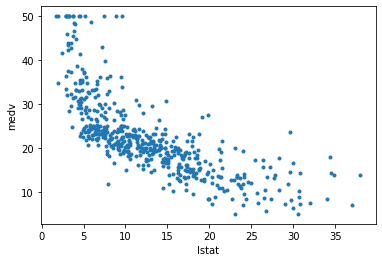

In [ ]:
from pylab import *
plot(df['lstat'], df['medv'], '.')
xlabel('lstat')
ylabel('medv')
plt.show()

In [ ]:
# let's use this as our dataset
X = df['lstat']
Z = df['medv']

# can't use pandas dataframe columns - you need to coerce to a list
X = list(X)
Z = list(Z)

# How to use AbsError in IPOPT

The sum of the squared differences is not the only way to measure errors.  Create an optimization model to find $a$ and $b$, but this time minimizing the sum of the absolute differences (https://en.wikipedia.org/wiki/Absolute_value). That is, the objective function now should be as follows:

$\sum\limits_{x \in X}|y(x) - z(x)|$



***But!*** We cannot use the function abs() with IPOPT! IPOPT requires functions to be continuous (https://en.wikipedia.org/wiki/Continuous_function) and twice differentiable (https://en.wikipedia.org/wiki/Differentiable_function), and abs() does not satisfy one of these conditions (which one?)

How can we address this issue? Try to think about a way of formulating the abs() function before checking the solution below. Tip: you can use linear expression for that.

# A First Power Model

Now let's apply the sum of absolute errors to the following regression expression:

$
\textrm{medv} = a \times lstat ^ b
$

**You will probably need to play with a few different initial values before you find a good solution.**

In [ ]:
# declare the model
model = ConcreteModel()

n_points = len(X)

# declare decision variables
model.a = Var(domain=Reals,initialize = 1000)
model.b = Var(domain=Reals, initialize = 1)
model.y = Var([i for i in range(n_points)],domain=Reals)

# Each variable abs[i] will represent |y[i] - z[i]|
model.abs_value = Var([i for i in range(n_points)],domain=NonNegativeReals)

# make sure you initialize y as '0', you can't do this directly
for i in range(n_points):
  model.y[i] = 0.0

# Constraints
model.constraints = ConstraintList()
# Predicted value
for i in range(n_points):
  x = X[i]
  model.constraints.add(model.y[i] == (model.a * x**model.b))


# The following constrains enforce abs[i] >= |y[i] - z[i]|
for i in range(n_points):
  model.constraints.add(model.abs_value[i] >= model.y[i] - Z[i]) # when model overestimates
  model.constraints.add(model.abs_value[i] >= -(model.y[i] - Z[i])) # when model underestimates

# this forces the model to choose whichever value is positive between these 2 constraints

# Because we want to minimize the sum of absolute values, the solver will pick the smallest possible values of abs[i]. 
# Therefore, we will have abs[i] = |y[i] - z[i]|, as we wanted
obj_expr = 0
for i in range(n_points):
  obj_expr += model.abs_value[i]
model.error = Objective(
                      expr = obj_expr,
                      sense = minimize)


# show the model you've created
model.pprint()

# solve it
SolverFactory('ipopt', executable='/content/ipopt').solve(model).write()
# show the results
print("Objective value = ", model.error())
print("A = ", model.a())
print("B = ", model.b())
a = model.a()
b = model.b()

3 Set Declarations
    abs_value_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :  506 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,

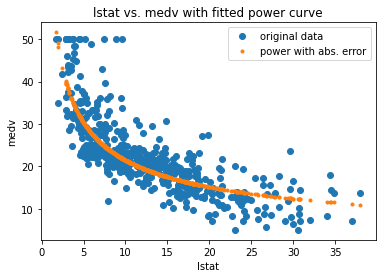

In [ ]:
# first, let's plot the original data
plt.plot(X, Z, 'o', label='original data')
# now, let's plot the line we got; note that we are using the linear regression expression as the second parameter of the plot function
plt.plot(X, a*np.array(X)**b, '.', label='power with abs. error')
plt.xlabel('lstat')
plt.ylabel('medv')
plt.title('lstat vs. medv with fitted power curve')
plt.legend()
plt.show()

In [ ]:
a, b

(67.9929789238683, -0.501036342331062)

# Kick It Up a Notch: Two Variables
Let's use two variables.

X will be LSTAT, Y will be RM, Z will be MEDV.


$
\textrm{medv} = a_1 \times lstat ^{b_1} + a_2 \times rm^{b_2}
$

In [ ]:
# X = lstat
X1 = list(df['lstat'])
# Y = rm
X2 = list(df['rm'])
# Z = medv
Z = list(df['medv'])

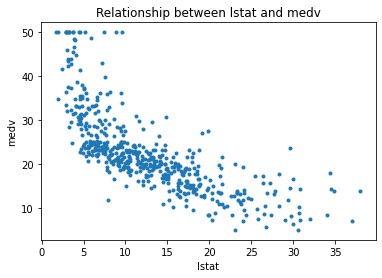

In [ ]:
# a little EDA on lstat
plot(X1,Z,'.')
plt.xlabel('lstat')
plt.ylabel('medv')
plt.title('Relationship between lstat and medv')
plt.show()

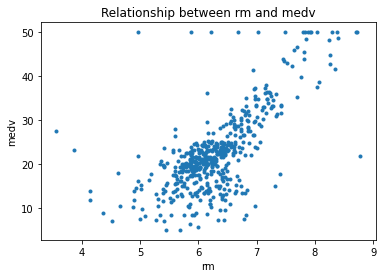

In [ ]:
# rm and on medv
plot(X2,Z,'.')
plt.xlabel('rm')
plt.ylabel('medv')
plt.title('Relationship between rm and medv')
plt.show()

Now let's use the same structure as before and see if we can make an accurate prediction.

In [ ]:
# declare the model
model = ConcreteModel()

n_points = len(X)

# declare decision variables
# just rename and paste

# a1 and b1 are for lstat
model.a1 = Var(domain=Reals,initialize = 1)
model.b1 = Var(domain=Reals, initialize = 1)

# a2 and b2 are for rm
model.a2 = Var(domain=Reals,initialize = 1)
model.b2 = Var(domain=Reals, initialize = 1)
model.y = Var([i for i in range(n_points)],domain=Reals)

# Each variable abs[i] will represent |y[i] - z[i]|
model.abs_value = Var([i for i in range(n_points)],domain=NonNegativeReals)


for i in range(n_points):
  model.y[i] = 0.0

# Constraints
model.constraints = ConstraintList()
# Predicted value
for i in range(n_points):
  x1 = X1[i]
  x2 = X2[i]
  model.constraints.add(model.y[i] == (model.a1 * x1**model.b1) + (model.a2 * x2**model.b2))


# The following constrains enforce abs[i] >= |y[i] - z[i]|
for i in range(n_points):
  model.constraints.add(model.abs_value[i] >= model.y[i] - Z[i]) # when model overestimates
  model.constraints.add(model.abs_value[i] >= -(model.y[i] - Z[i])) # when model underestimates

# choose the positive value!

# Because we want to minimize the sum of absolute values, the solver will pick the smallest possible values of abs[i]. 
# Therefore, we will have abs[i] = |y[i] - z[i]|, as we wanted
obj_expr = 0
for i in range(n_points):
  obj_expr += model.abs_value[i]
model.error = Objective(
                      expr = obj_expr,
                      sense = minimize)


# show the model you've created
model.pprint()

3 Set Declarations
    abs_value_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :  506 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,

In [ ]:
# solve it
SolverFactory('ipopt', executable='/content/ipopt').solve(model).write()
# show the results
print("Objective value = ", model.error())
print("a1 = ", model.a1())
print("b1 = ", model.b1())
print("a2 = ", model.a2())
print("b2 = ", model.b2())

a1 = model.a1()
b1 = model.b1()
a2 = model.a2()
b2 = model.b2()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1518
  Number of variables: 1016
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Solved To Acceptable Level.
  Termination condition: optimal
  Id: 1
  Error rc: 0
  Time: 29.629075527191162
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed:

Now let's see if we can evaluate the output.

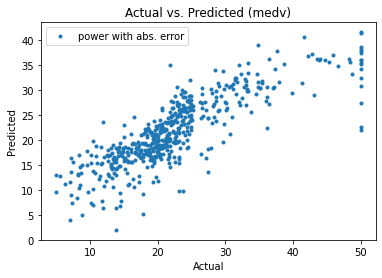

In [ ]:
# the actual vs. predicted of our model
plt.plot(Z, a1*np.array(X1)**b1 + a2*np.array(X2)**b2, '.', label='power with abs. error')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted (medv)')
plt.legend()
plt.show()

Good looking model!

# On Your Own
Try to evaluate the error metrics of this model, try to include other variables into your regression.